<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

## 0. python imports

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols # ordinary least squares

## 1. data loading

let's load data about interest rate in different cities and our well-known dataset from cars...

In [18]:
rate = pd.read_csv('./data/rate_by_city.csv')
rate.head()

,Rate,City
0,13.75,1
1,13.75,1
2,13.50,1
3,13.50,1
4,13.00,1


In [19]:
auto = pd.read_csv('./data/auto-mpg.csv')
auto.head() # mpg stands for miles per gallon, or fuel consumption

,mpg,cylinders,displacement,horse_power,weight,acceleration,model_year,car_name
0,18.0,8,307.0,130.0,3504,12.0,70,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693,11.5,70,"\t""buick skylark 320"""
2,18.0,8,318.0,150.0,3436,11.0,70,"\t""plymouth satellite"""
3,16.0,8,304.0,150.0,3433,12.0,70,"\t""amc rebel sst"""
4,17.0,8,302.0,140.0,3449,10.5,70,"\t""ford torino"""


## 2. anova using scipy

let's check if interest rates are different among cities... data must be rearranged, there are several ways to do that...

In [21]:
rate['city_count'] = rate.groupby('City').cumcount()
rate_pivot = rate.pivot(columns='City', values='Rate', index='city_count')
rate_pivot

City,1,2,3,4,5,6
city_count,,,,,,
0,13.75,14.25,14.00,15.00,14.50,13.50
1,13.75,13.00,14.00,14.00,14.00,12.25
2,13.50,12.75,13.51,13.75,14.00,12.25
3,13.50,12.50,13.50,13.59,13.90,12.00
4,13.00,12.50,13.50,13.25,13.75,12.00
5,13.00,12.40,13.25,12.97,13.25,12.00
6,13.00,12.30,13.00,12.50,13.00,12.00
7,12.75,11.90,12.50,12.25,12.50,11.90
8,12.50,11.90,12.50,11.89,12.45,11.90


https://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

In [22]:
rate_pivot_b = pd.DataFrame({f'city_{i}': rate.loc[rate['City'] == i, 'Rate'].values 
                           for i in rate['City'].unique()})
rate_pivot_b

,city_1,city_2,city_3,city_4,city_5,city_6
0,13.75,14.25,14.00,15.00,14.50,13.50
1,13.75,13.00,14.00,14.00,14.00,12.25
2,13.50,12.75,13.51,13.75,14.00,12.25
3,13.50,12.50,13.50,13.59,13.90,12.00
4,13.00,12.50,13.50,13.25,13.75,12.00
5,13.00,12.40,13.25,12.97,13.25,12.00
6,13.00,12.30,13.00,12.50,13.00,12.00
7,12.75,11.90,12.50,12.25,12.50,11.90
8,12.50,11.90,12.50,11.89,12.45,11.90


scipy anova test get lists (or arrays) in an `*args` fashion (can pass as many arguments as samples to include in the anova test)...

In [23]:
# this is just a silly example...
f_oneway([1,2,3], [4, 5, 3, 5], [5, 6, 7, 6, 7, 8, 9, 10])

F_onewayResult(statistic=16.663917525773186, pvalue=0.0003442687602689353)

In [24]:
# this is our real data from cities
f_oneway(*[rate_pivot[i] for i in range(1,7)])

F_onewayResult(statistic=4.8293848737024, pvalue=0.001174551414504048)

In [29]:
# this is another way to pass data (same result)
f_oneway(*{f'city_{i}': rate.loc[rate['City'] == i, 'Rate'].values 
                           for i in rate['City'].unique()}.values())

F_onewayResult(statistic=4.8293848737024, pvalue=0.001174551414504048)

let's compute class example hand-made and using scipy...

In [31]:
# scipy implementation
f_oneway([1, 2, 3], [3, 4, 5], [5, 6, 7])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

In [32]:
sample_data = np.array([[1, 2, 3], [3, 4, 5], [5, 6, 7]]).T
sample_data

array([[1, 3, 5],
       [2, 4, 6],
       [3, 5, 7]])

In [36]:
m = sample_data.shape[1]
n = sample_data.shape[0]
display(m, n)

3

3

In [35]:
mean = sample_data.mean()
mean

4.0

In [37]:
sst = ((sample_data - mean) ** 2).sum()
df_sst = m * n -1
display(sst, df_sst)

30.0

8

In [38]:
col_means = sample_data.mean(axis=0)
col_means

array([2., 4., 6.])

In [39]:
ssw = ((sample_data - col_means) ** 2).sum()
df_ssw = m * (n - 1)
display(ssw, df_ssw)

6.0

6

In [41]:
ssb = (((col_means - mean) ** 2) * n).sum()
df_ssb = m - 1
display(ssb, df_ssb)

24.0

2

In [42]:
f = (ssb / df_ssb) / (ssw / df_ssw)
f

12.0

In [48]:
# in a single cell

m = sample_data.shape[1]
n = sample_data.shape[0]
mean = sample_data.mean()
col_means = sample_data.mean(axis=0)
sst = np.power((sample_data - mean), 2).sum()
sst_df = m * n - 1
ssw = np.power(sample_data - col_means, 2).sum()
ssw_df = (n - 1) * m
ssb = (np.power((col_means - mean), 2) * n).sum()
ssb_df = m -1
f = (ssb / ssb_df) / (ssw / ssw_df)
f

12.0

let's import f distribution from scipy, so we can use it to get the probability associated with that value of f...

In [50]:
from scipy.stats import f
1 - f.cdf(12, dfn=ssb_df, dfd=ssw_df)

0.008000000000000007

In [51]:
f_oneway(sample_data[:, 0], sample_data[:, 1], sample_data[:, 2])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html

## 3. anova using statsmodels

there are other tools (more verbose) to perform that kind of tests...

* https://stackoverflow.com/questions/30650257/ols-using-statsmodel-formula-api-versus-statsmodel-ap
* http://www.statsmodels.org/dev/example_formulas.html
* C(variable) is for categorical variables
* Types of anova taking into account interactions between samples (https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/)

In [59]:
formula = 'Rate ~ C(City)'
model = ols(formula=formula, data=rate).fit()

In [60]:
anova_table = sm.stats.anova_lm(model, typ='II')
anova_table

,sum_sq,df,F,PR(>F)
C(City),10.945667,5.0,4.829385,0.001175
Residual,21.758133,48.0,NaN,NaN


## 4. linear regression using scipy

In [61]:
reg_result = linregress(auto['acceleration'], auto['mpg'])
reg_names = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
print('\n'.join([f'{reg_names[i]}: {reg_result[i]}' 
                 for i in range(len(reg_result))]))

slope: 1.1912045293502274
intercept: 4.9697930042539085
r_value: 0.4202889121016507
p_value: 1.8230915350787203e-18
std_err: 0.12923643283101396


In [62]:
x = np.linspace(auto['acceleration'].min(), auto['acceleration'].max(), 50)
y = reg_result[1] + reg_result[0] * x

Plot results:

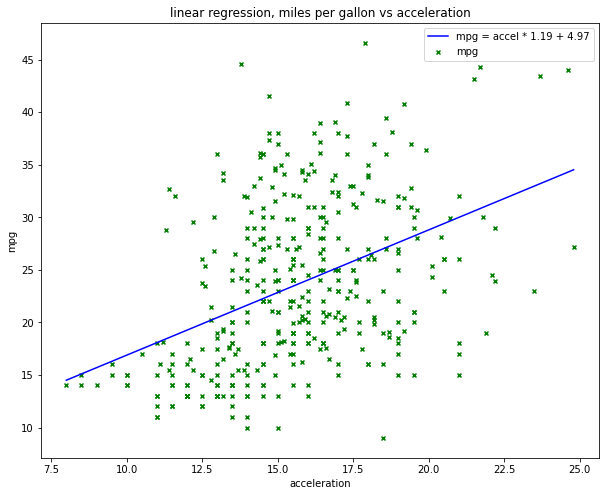

In [63]:
plt.figure(figsize=(10, 8))
plt.plot(x, y, c='b', 
         label=f'mpg = accel * {reg_result[0]:.2f} + {reg_result[1]:.2f}')
plt.scatter(auto['acceleration'], 
            auto['mpg'], 
            marker='x', 
            c='g', 
            s=16,
            label='mpg')
plt.title('linear regression, miles per gallon vs acceleration')
plt.xlabel('acceleration')
plt.ylabel('mpg')
plt.legend()
plt.show()

## 5. linear regression using statsmodels

https://www.theanalysisfactor.com/why-anova-and-linear-regression-are-the-same-analysis/

for only one variable (acceleration)

In [64]:
Y = auto['mpg']
X = sm.add_constant(auto['acceleration'])

model = sm.OLS(Y, X).fit() # ordinary least squares
predictions = model.predict(X)

In [65]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     84.96
Date:                Sat, 29 Aug 2020   Prob (F-statistic):           1.82e-18
Time:                        10:12:28   Log-Likelihood:                -1343.9
No. Observations:                 398   AIC:                             2692.
Df Residuals:                     396   BIC:                             2700.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.9698      2.043      2.432      0.015       0.953       8.987
acceleration     1.1912      0.129      9.217      0.000       0.937       1.445
==============================================================================
Omnibus:                       17.459   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.214
Skew:                           0.497   Prob(JB):                     0.000111
Kurtosis:                       2.670   Cond. No.                         91.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

for several variables

In [66]:
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horse_power', 'weight',
       'acceleration', 'model_year', 'car_name'],
      dtype='object')

In [67]:
X = sm.add_constant(auto[[
#     'acceleration', 
#     'cylinders',
    'weight', 
#     'horse_power',
    'model_year', 
#     'displacement'
                         ]].apply(lambda x: x.fillna(x.mean())))
Y = auto['mpg']
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     830.4
Date:                Sat, 29 Aug 2020   Prob (F-statistic):          3.26e-142
Time:                        10:12:30   Log-Likelihood:                -1054.3
No. Observations:                 398   AIC:                             2115.
Df Residuals:                     395   BIC:                             2127.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.1980      3.968     -3.578      0.000     -21.998      -6.398
weight        -0.0067      0.000    -31.161      0.000      -0.007      -0.006
model_year     0.7566      0.049     15.447      0.000       0.660       0.853
==============================================================================
Omnibus:                       41.827   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.734
Skew:                           0.665   Prob(JB):                     1.19e-15
Kurtosis:                       4.541   Cond. No.                     7.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* check table for significant variables (model_year, weight)

¿car brand? not suitable for linear regression out of the box, one hot encoding needed!

In [69]:
auto['brand'] = auto['car_name'] \
                .str.lstrip('\t') \
                .str.strip('""') \
                .str.split(' ') \
                .str[0].astype('category')

pd.get_dummies(auto['brand'].head())

,amc,audi,bmw,buick,cadillac,capri,chevroelt,chevrolet,chevy,chrysler,...,renault,saab,subaru,toyota,toyouta,triumph,vokswagen,volkswagen,volvo,vw
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Alternative using scikit-learn:

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = auto[[
#     'acceleration', 
#     'cylinders',
    'weight', 
#     'horse_power',
    'model_year', 
#     'displacement'
                         ]]

y = auto['mpg']

model = LinearRegression(fit_intercept=True)
model.fit(X, y)
predictions = model.predict(X)

print(r2_score(y_true=y, y_pred=predictions))
print(model.coef_)
print(model.intercept_)

0.8078621345742751
[-0.00666388  0.75657249]
-14.197981575720995


<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>